# Regresión para Predecir Monto de Fraude en Canastas

## Objetivo
Predecir el **costo total** de transacciones fraudulentas utilizando modelos de regresión, trabajando únicamente con canastas donde `fraud_flag=1`.

## Estrategia
1. Transformar columnas de artículos a binarias (presencia/ausencia)
2. Filtrar solo transacciones fraudulentas
3. Reducir dimensionalidad (2,449 artículos)
4. Entrenar dos modelos de regresión:
   - Linear Regression (baseline)
   - Regresión Robusta (HuberRegressor)
5. Análisis detallado de errores de predicción

---

## 1. Importación de Librerías

In [47]:
# Librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocesamiento
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

# Modelos de regresión
from sklearn.linear_model import LinearRegression, HuberRegressor

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Análisis estadístico
from scipy import stats

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Librerías importadas exitosamente")

✓ Librerías importadas exitosamente


---
## 2. Carga y Exploración Inicial de Datos

In [48]:
# Cargar el dataset
ruta_datos = '../Datos/FraudeCanastas.csv'
df = pd.read_csv(ruta_datos)

print("=" * 70)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 70)
print(f"Dimensiones: {df.shape[0]:,} filas × {df.shape[1]:,} columnas")
print(f"Tamaño en memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nPrimeras columnas:")
print(df.columns[:10].tolist())
print("\nÚltimas columnas:")
print(df.columns[-10:].tolist())

INFORMACIÓN GENERAL DEL DATASET
Dimensiones: 9,319 filas × 2,457 columnas
Tamaño en memoria: 174.69 MB

Primeras columnas:
['ID', 'APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90', 'AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H', 'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE', 'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI', 'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE', 'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND', 'AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD', 'AUDIO ACCESSORIES | APPLE | AIRPODS PRO', 'AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX']

Últimas columnas:
['WOMEN S NIGHTWEAR | ANYDAY RETAILER | ANYDAY RETAILER LEOPARD PRINT JERSEY PY', 'WOMEN S NIGHTWEAR | RETAILER | RETAILER CLEO VELOUR JOGGER LOUNGE PANT', 'WOMEN S NIGHTWEAR | SOSANDAR | SOSANDAR ZEBRA PRINT PYJAMA BOTTOMS BLACK 10', '

In [49]:
# Estructura del dataset
print("=" * 70)
print("ESTRUCTURA DEL DATASET")
print("=" * 70)

# Identificar tipos de columnas
col_id = 'ID'
columnas_agregadas = ['Nb_of_items', 'total_of_items', 'costo_total', 
                      'costo_medio_item', 'costo_item_max', 'costo_item_min']
col_target = 'fraud_flag'

# Columnas de artículos (todas excepto ID, agregadas y target)
columnas_articulos = [col for col in df.columns if col not in [col_id] + columnas_agregadas + [col_target]]

print(f"\nColumna ID: {col_id}")
print(f"Columnas de artículos: {len(columnas_articulos)} columnas")
print(f"Columnas agregadas: {columnas_agregadas}")
print(f"Columna target (etiqueta): {col_target}")

print(f"\n\nTotal de columnas: {1 + len(columnas_articulos) + len(columnas_agregadas) + 1} = {df.shape[1]}")

ESTRUCTURA DEL DATASET

Columna ID: ID
Columnas de artículos: 2449 columnas
Columnas agregadas: ['Nb_of_items', 'total_of_items', 'costo_total', 'costo_medio_item', 'costo_item_max', 'costo_item_min']
Columna target (etiqueta): fraud_flag


Total de columnas: 2457 = 2457


In [50]:
# Valores faltantes
print("=" * 70)
print("VALORES FALTANTES")
print("=" * 70)
valores_faltantes = df.isnull().sum()
if valores_faltantes.sum() == 0:
    print("✓ No hay valores faltantes en el dataset")
else:
    print(f"Total de valores faltantes: {valores_faltantes.sum():,}")
    print("\nColumnas con valores faltantes:")
    print(valores_faltantes[valores_faltantes > 0].sort_values(ascending=False))

VALORES FALTANTES
✓ No hay valores faltantes en el dataset


In [ ]:
# Estadísticas de la variable etiqueta
print("=" * 70)
print("DISTRIBUCIÓN DE FRAUD_FLAG")
print("=" * 70)
distribucion_fraude = df[col_target].value_counts().sort_index()
print(distribucion_fraude)
print(f"\nProporción de fraudes: {df[col_target].mean():.2%}")
print(f"Total de transacciones fraudulentas: {int(df[col_target].sum())}")
print(f"Total de transacciones legítimas: {int((1 - df[col_target]).sum())}")

DISTRIBUCIÓN DE FRAUD_FLAG
fraud_flag
0.0    8000
1.0    1319
Name: count, dtype: int64

Proporción de fraudes: 14.15%
Total de transacciones fraudulentas: 1319
Total de transacciones legítimas: 8000


In [52]:
# Estadísticas descriptivas de variables agregadas
print("=" * 70)
print("ESTADÍSTICAS DESCRIPTIVAS - VARIABLES AGREGADAS")
print("=" * 70)
print(df[columnas_agregadas].describe())

ESTADÍSTICAS DESCRIPTIVAS - VARIABLES AGREGADAS
       Nb_of_items  total_of_items   costo_total  costo_medio_item  \
count  9319.000000     9319.000000   9319.000000       9319.000000   
mean      1.774761        1.856852   1337.801052        898.376189   
std       1.541868        1.922323   1070.597321        734.425487   
min       1.000000        1.000000    219.000000         41.615385   
25%       1.000000        1.000000    838.000000        445.500000   
50%       1.000000        1.000000   1124.000000        745.400000   
75%       2.000000        2.000000   1612.000000       1150.000000   
max      38.000000       44.000000  24551.000000      19999.000000   

       costo_item_max  costo_item_min  
count     9319.000000     9319.000000  
mean      1184.433416      647.735165  
std        786.942018      841.194373  
min        130.000000        0.000000  
25%        749.000000        7.000000  
50%       1049.000000      379.000000  
75%       1415.500000     1099.000000  
m

In [53]:
# Visualizar primeras filas
print("=" * 70)
print("PRIMERAS 5 FILAS DEL DATASET")
print("=" * 70)
print("\nColumnas: ID + variables agregadas + fraud_flag")
columnas_mostrar = [col_id] + columnas_agregadas + [col_target]
display(df[columnas_mostrar].head())

PRIMERAS 5 FILAS DEL DATASET

Columnas: ID + variables agregadas + fraud_flag


,ID,Nb_of_items,total_of_items,costo_total,costo_medio_item,costo_item_max,costo_item_min,fraud_flag
0,130,2,2,1299,649.500000,1299,0.0,1.0
1,195,3,3,4119,1373.000000,2470,0.0,1.0
2,217,2,2,2806,1403.000000,2799,7.0,1.0
3,552,2,2,1206,603.000000,1199,7.0,1.0
4,854,19,27,1807,66.925926,195,4.0,1.0


---
## 3. Preprocesamiento de Datos

### 3.1 Transformación de Artículos a Variables Binarias

In [54]:
print("=" * 70)
print("TRANSFORMACIÓN DE ARTÍCULOS A VARIABLES BINARIAS")
print("=" * 70)

# Crear copia para no modificar el dataset original
df_procesado = df.copy()

# Convertir columnas de artículos a binarias (0 si es 0, 1 si es > 0)
print(f"\nConvirtiendo {len(columnas_articulos)} columnas de artículos a binarias...")
for col in columnas_articulos:
    df_procesado[col] = (df_procesado[col] > 0).astype(int)

print("✓ Transformación completada")

# Verificar la transformación
print("\nVerificación: Valores únicos en columnas de artículos después de transformación:")
valores_unicos = df_procesado[columnas_articulos].nunique().unique()
print(f"Valores únicos encontrados: {valores_unicos}")
if len(valores_unicos) <= 2 and all(v <= 2 for v in valores_unicos):
    print("✓ Todas las columnas de artículos son ahora binarias (0 o 1)")
else:
    print("⚠ Advertencia: Algunas columnas no son binarias")

TRANSFORMACIÓN DE ARTÍCULOS A VARIABLES BINARIAS

Convirtiendo 2449 columnas de artículos a binarias...
✓ Transformación completada

Verificación: Valores únicos en columnas de artículos después de transformación:
Valores únicos encontrados: [2]
✓ Todas las columnas de artículos son ahora binarias (0 o 1)


In [55]:
# Mostrar ejemplo de transformación
print("=" * 70)
print("EJEMPLO DE TRANSFORMACIÓN")
print("=" * 70)
print("\nPrimeros 5 artículos - Valores ORIGINALES:")
print(df[columnas_articulos[:5]].head(3))
print("\nPrimeros 5 artículos - Valores TRANSFORMADOS (binarios):")
print(df_procesado[columnas_articulos[:5]].head(3))

EJEMPLO DE TRANSFORMACIÓN

Primeros 5 artículos - Valores ORIGINALES:
   APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90  \
0                                           0.0   
1                                           0.0   
2                                           0.0   

   AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H  \
0                                                0.0                                 
1                                                0.0                                 
2                                                0.0                                 

   AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE  \
0                                                0.0                   
1                                                0.0                   
2                                                0.0                   

   AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI  \
0     

### 3.2 Filtrado: Solo Transacciones Fraudulentas

In [56]:
print("=" * 70)
print("FILTRADO: SOLO TRANSACCIONES FRAUDULENTAS")
print("=" * 70)

# Filtrar solo fraudes (fraud_flag == 1)
df_fraudes = df_procesado[df_procesado[col_target] == 1.0].copy()

print(f"\nFilas originales: {df_procesado.shape[0]:,}")
print(f"Filas después del filtro (solo fraudes): {df_fraudes.shape[0]:,}")
print(f"Porcentaje de datos retenidos: {(df_fraudes.shape[0] / df_procesado.shape[0]) * 100:.2f}%")

# Verificar que el filtrado es correcto
if df_fraudes[col_target].nunique() == 1 and df_fraudes[col_target].iloc[0] == 1.0:
    print("\n✓ Filtrado exitoso: Todos los registros tienen fraud_flag = 1")
else:
    print("\n⚠ Advertencia: El filtrado puede no ser correcto")

# Verificar tamaño de muestra
if df_fraudes.shape[0] < 100:
    print(f"\n⚠ ADVERTENCIA: Solo {df_fraudes.shape[0]} muestras disponibles.")
    print("   Esto puede ser insuficiente para entrenar modelos robustos.")
elif df_fraudes.shape[0] < 500:
    print(f"\n⚠ Nota: {df_fraudes.shape[0]} muestras es un tamaño moderado.")
    print("   Se recomienda usar cross-validation para mejor evaluación.")
else:
    print(f"\n✓ Tamaño de muestra adecuado: {df_fraudes.shape[0]} transacciones fraudulentas")

FILTRADO: SOLO TRANSACCIONES FRAUDULENTAS

Filas originales: 9,319
Filas después del filtro (solo fraudes): 1,319
Porcentaje de datos retenidos: 14.15%

✓ Filtrado exitoso: Todos los registros tienen fraud_flag = 1

✓ Tamaño de muestra adecuado: 1319 transacciones fraudulentas


### 3.3 Preparación de Features y Target

In [57]:
print("=" * 70)
print("PREPARACIÓN DE FEATURES Y TARGET")
print("=" * 70)

# Definir variable objetivo (target)
y = df_fraudes['costo_total'].copy()

# Definir features (todas excepto ID, fraud_flag y costo_total)
features_numericas = ['Nb_of_items', 'total_of_items', 'costo_medio_item', 
                      'costo_item_max', 'costo_item_min']
features = columnas_articulos + features_numericas
X = df_fraudes[features].copy()

print(f"\nVariable objetivo (y): costo_total")
print(f"  - Mínimo: ${y.min():,.2f}")
print(f"  - Máximo: ${y.max():,.2f}")
print(f"  - Media: ${y.mean():,.2f}")
print(f"  - Mediana: ${y.median():,.2f}")
print(f"  - Desviación estándar: ${y.std():,.2f}")

print(f"\nFeatures (X): {X.shape[1]:,} variables")
print(f"  - Artículos binarios: {len(columnas_articulos):,}")
print(f"  - Variables numéricas agregadas: {len(features_numericas)}")
print(f"    {features_numericas}")

print(f"\nDimensiones finales:")
print(f"  - X: {X.shape}")
print(f"  - y: {y.shape}")

PREPARACIÓN DE FEATURES Y TARGET

Variable objetivo (y): costo_total
  - Mínimo: $305.00
  - Máximo: $24,551.00
  - Media: $1,614.99
  - Mediana: $1,379.00
  - Desviación estándar: $1,247.23

Features (X): 2,454 variables
  - Artículos binarios: 2,449
  - Variables numéricas agregadas: 5
    ['Nb_of_items', 'total_of_items', 'costo_medio_item', 'costo_item_max', 'costo_item_min']

Dimensiones finales:
  - X: (1319, 2454)
  - y: (1319,)


---
## 4. Análisis Exploratorio de Fraudes

### 4.1 Distribución del Costo Total en Fraudes

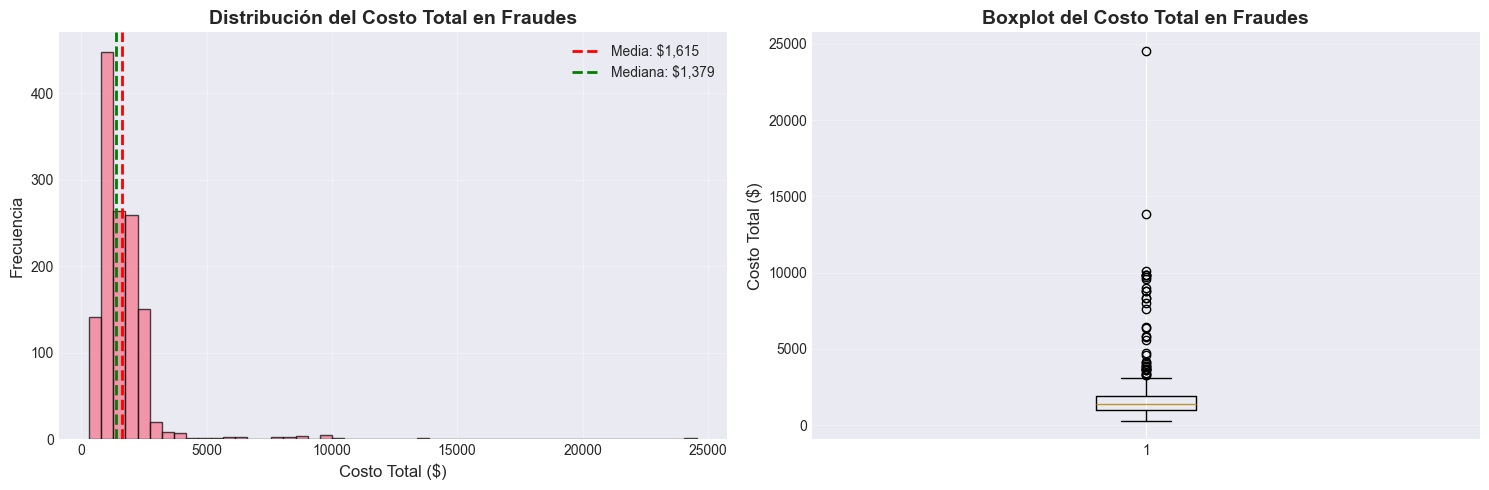


Estadísticas de Distribución:
Asimetría (Skewness): 7.828
Curtosis (Kurtosis): 105.214
→ Distribución altamente asimétrica hacia la derecha (muchos valores bajos, pocos muy altos)


In [58]:
# Distribución de costo_total
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma
axes[0].hist(y, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(y.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: ${y.mean():,.0f}')
axes[0].axvline(y.median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: ${y.median():,.0f}')
axes[0].set_xlabel('Costo Total ($)', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('Distribución del Costo Total en Fraudes', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
axes[1].boxplot(y, vert=True)
axes[1].set_ylabel('Costo Total ($)', fontsize=12)
axes[1].set_title('Boxplot del Costo Total en Fraudes', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Estadísticas de asimetría
print("\nEstadísticas de Distribución:")
print(f"Asimetría (Skewness): {stats.skew(y):.3f}")
print(f"Curtosis (Kurtosis): {stats.kurtosis(y):.3f}")
if stats.skew(y) > 1:
    print("→ Distribución altamente asimétrica hacia la derecha (muchos valores bajos, pocos muy altos)")
elif stats.skew(y) > 0.5:
    print("→ Distribución moderadamente asimétrica hacia la derecha")
else:
    print("→ Distribución aproximadamente simétrica")

In [59]:
# Identificar outliers usando método IQR
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = y[(y < limite_inferior) | (y > limite_superior)]

print("=" * 70)
print("ANÁLISIS DE OUTLIERS (Método IQR)")
print("=" * 70)
print(f"Q1 (Cuartil 25%): ${Q1:,.2f}")
print(f"Q3 (Cuartil 75%): ${Q3:,.2f}")
print(f"IQR: ${IQR:,.2f}")
print(f"Límite inferior: ${limite_inferior:,.2f}")
print(f"Límite superior: ${limite_superior:,.2f}")
print(f"\nNúmero de outliers: {len(outliers)} ({len(outliers)/len(y)*100:.2f}% del total)")
if len(outliers) > 0:
    print(f"Rango de outliers: ${outliers.min():,.2f} - ${outliers.max():,.2f}")
    print("\n→ La presencia de outliers justifica el uso de Regresión Robusta (HuberRegressor)")

ANÁLISIS DE OUTLIERS (Método IQR)
Q1 (Cuartil 25%): $1,000.50
Q3 (Cuartil 75%): $1,899.00
IQR: $898.50
Límite inferior: $-347.25
Límite superior: $3,246.75

Número de outliers: 37 (2.81% del total)
Rango de outliers: $3,305.00 - $24,551.00

→ La presencia de outliers justifica el uso de Regresión Robusta (HuberRegressor)


### 4.2 Artículos Más Frecuentes en Fraudes

In [60]:
# Calcular frecuencia de artículos
frecuencia_articulos = X[columnas_articulos].sum().sort_values(ascending=False)
porcentaje_articulos = (frecuencia_articulos / len(X)) * 100

print("=" * 70)
print("TOP 20 ARTÍCULOS MÁS FRECUENTES EN FRAUDES")
print("=" * 70)
top20_articulos = pd.DataFrame({
    'Artículo': frecuencia_articulos.head(20).index,
    'Frecuencia': frecuencia_articulos.head(20).values,
    'Porcentaje': porcentaje_articulos.head(20).values
})
top20_articulos['Artículo'] = top20_articulos['Artículo'].str[:60] + '...'  # Truncar nombres largos
print(top20_articulos.to_string(index=False))

TOP 20 ARTÍCULOS MÁS FRECUENTES EN FRAUDES
                                                       Artículo  Frecuencia  Porcentaje
                     FULFILMENT CHARGE | RETAILER | RETAILER...         509   38.589841
COMPUTERS | APPLE | 2020 APPLE MACBOOK PRO 13 TOUCH BAR M1 P...         172   13.040182
COMPUTERS | APPLE | 2020 APPLE MACBOOK AIR 13 3 RETINA DISPL...         156   11.827142
COMPUTERS | APPLE | 2021 APPLE MACBOOK PRO 14 M1 PRO PROCESS...         155   11.751327
COMPUTERS | APPLE | 2021 APPLE MACBOOK PRO 16 M1 PRO PROCESS...          76    5.761941
COMPUTERS | APPLE | 2021 APPLE IPAD PRO 11 M1 PROCESSOR IOS ...          71    5.382866
COMPUTERS | APPLE | 2021 APPLE IPAD PRO 12 9 M1 PROCESSOR IO...          64    4.852161
COMPUTERS | APPLE | 2020 APPLE MACBOOK PRO 13 TOUCH BAR INTE...          55    4.169826
COMPUTERS | APPLE | 2021 APPLE IPAD PRO 12 9 M1 PROCESSOR IO...          41    3.108415
COMPUTERS | APPLE | 2021 APPLE IPAD PRO 12 9 M1 PROCESSOR IO...          39  

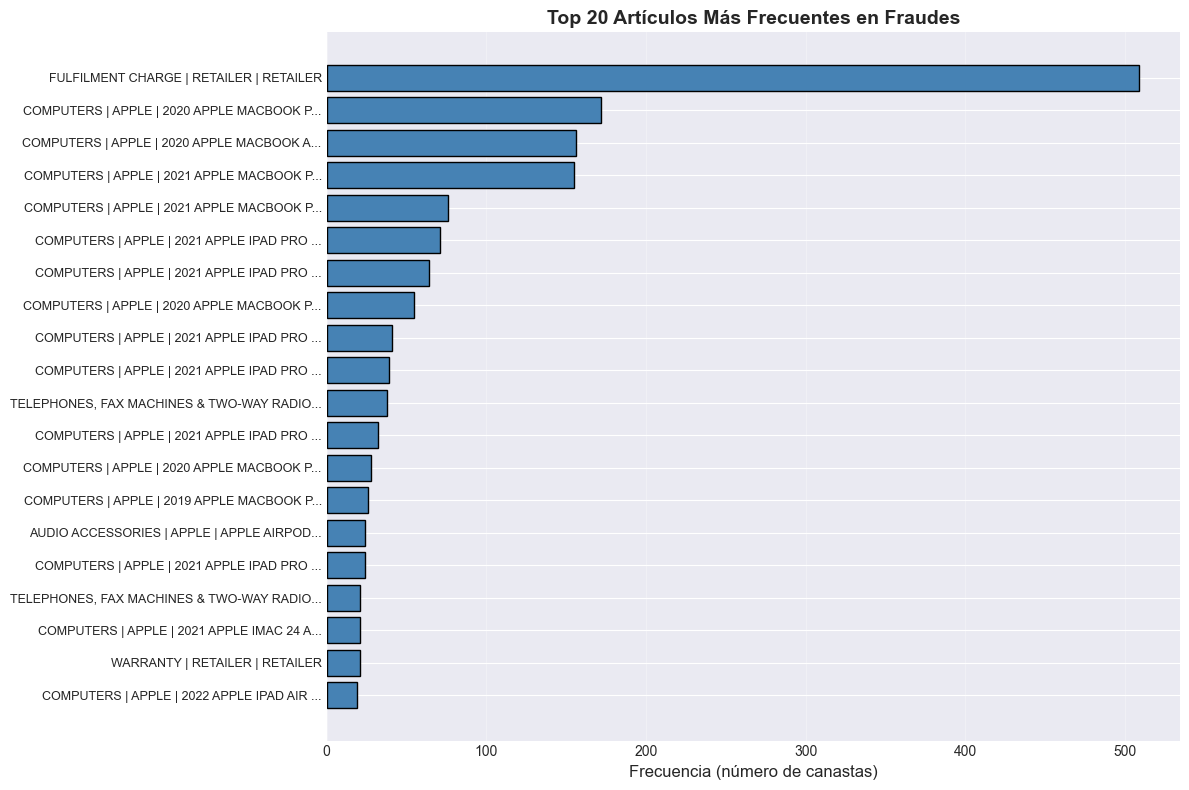

In [61]:
# Visualización de top 20 artículos
plt.figure(figsize=(12, 8))
top20 = frecuencia_articulos.head(20)
articulos_nombres = [nombre[:40] + '...' if len(nombre) > 40 else nombre for nombre in top20.index]
plt.barh(range(len(top20)), top20.values, color='steelblue', edgecolor='black')
plt.yticks(range(len(top20)), articulos_nombres, fontsize=9)
plt.xlabel('Frecuencia (número de canastas)', fontsize=12)
plt.title('Top 20 Artículos Más Frecuentes en Fraudes', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [62]:
# Estadísticas generales de artículos
print("=" * 70)
print("ESTADÍSTICAS GENERALES DE ARTÍCULOS EN FRAUDES")
print("=" * 70)
articulos_por_canasta = X[columnas_articulos].sum(axis=1)
print(f"Promedio de artículos únicos por canasta: {articulos_por_canasta.mean():.2f}")
print(f"Mediana de artículos únicos por canasta: {articulos_por_canasta.median():.0f}")
print(f"Mínimo de artículos en una canasta: {articulos_por_canasta.min():.0f}")
print(f"Máximo de artículos en una canasta: {articulos_por_canasta.max():.0f}")

articulos_con_compras = (frecuencia_articulos > 0).sum()
articulos_sin_compras = len(columnas_articulos) - articulos_con_compras
print(f"\nArtículos que aparecen al menos una vez: {articulos_con_compras:,} ({articulos_con_compras/len(columnas_articulos)*100:.1f}%)")
print(f"Artículos que NUNCA aparecen: {articulos_sin_compras:,} ({articulos_sin_compras/len(columnas_articulos)*100:.1f}%)")
print("\n→ Los artículos que nunca aparecen pueden ser eliminados sin pérdida de información")

ESTADÍSTICAS GENERALES DE ARTÍCULOS EN FRAUDES
Promedio de artículos únicos por canasta: 1.69
Mediana de artículos únicos por canasta: 2
Mínimo de artículos en una canasta: 1
Máximo de artículos en una canasta: 18

Artículos que aparecen al menos una vez: 298 (12.2%)
Artículos que NUNCA aparecen: 2,151 (87.8%)

→ Los artículos que nunca aparecen pueden ser eliminados sin pérdida de información


### 4.3 Correlación entre Variables Numéricas y Costo Total

CORRELACIÓN DE VARIABLES NUMÉRICAS CON COSTO_TOTAL
costo_item_max           : +0.7866
costo_medio_item         : +0.5993
total_of_items           : +0.1652
costo_item_min           : +0.1638
Nb_of_items              : +0.1028


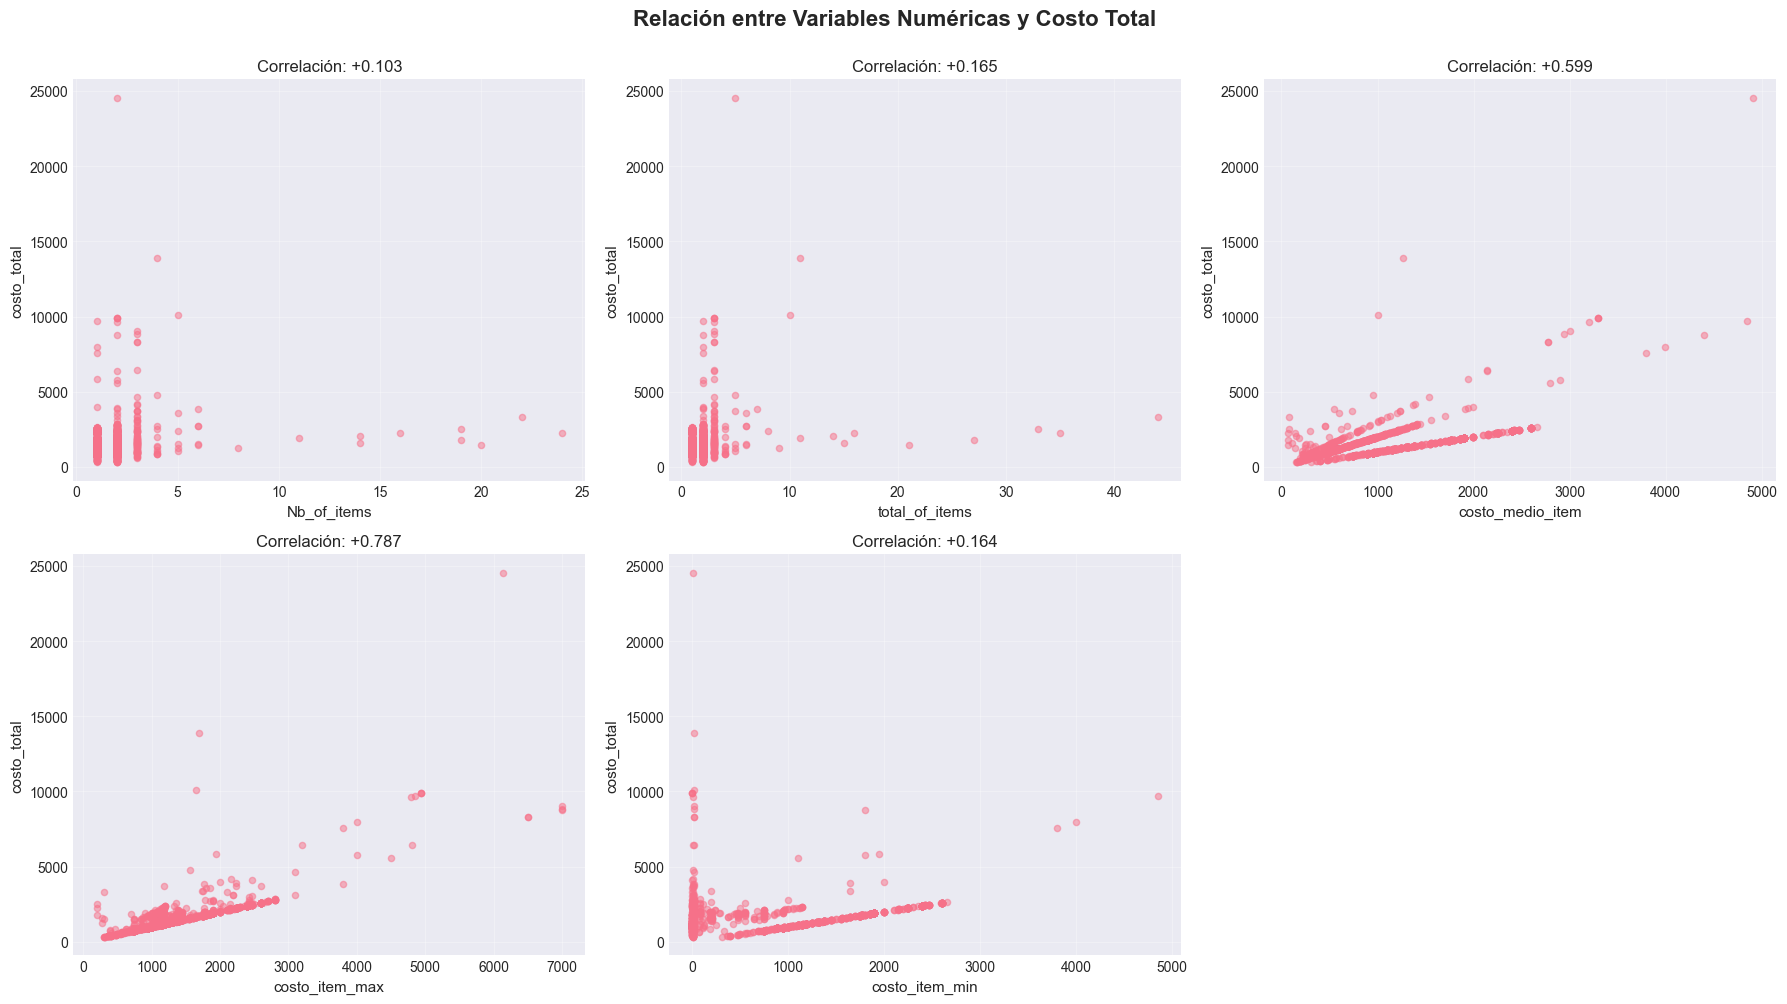

In [63]:
# Correlación con costo_total
variables_para_correlacion = features_numericas
datos_correlacion = df_fraudes[variables_para_correlacion + ['costo_total']].copy()
correlaciones = datos_correlacion.corr()['costo_total'].drop('costo_total').sort_values(ascending=False)

print("=" * 70)
print("CORRELACIÓN DE VARIABLES NUMÉRICAS CON COSTO_TOTAL")
print("=" * 70)
for var, corr in correlaciones.items():
    print(f"{var:25s}: {corr:+.4f}")

# Visualización
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, var in enumerate(variables_para_correlacion):
    axes[idx].scatter(df_fraudes[var], y, alpha=0.5, s=20)
    axes[idx].set_xlabel(var, fontsize=11)
    axes[idx].set_ylabel('costo_total', fontsize=11)
    axes[idx].set_title(f'Correlación: {correlaciones[var]:+.3f}', fontsize=12)
    axes[idx].grid(True, alpha=0.3)

# Eliminar subplot vacío
fig.delaxes(axes[5])

plt.suptitle('Relación entre Variables Numéricas y Costo Total', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

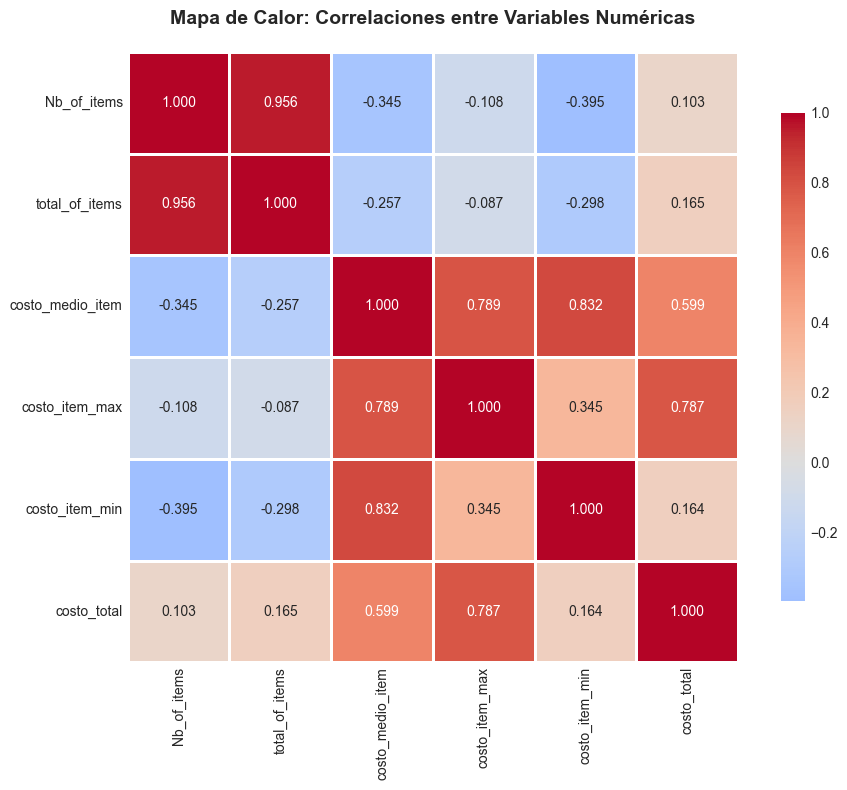


Interpretación:
- Correlación cercana a +1: relación positiva fuerte
- Correlación cercana a -1: relación negativa fuerte
- Correlación cercana a 0: poca o ninguna relación lineal


In [64]:
# Heatmap de correlaciones
plt.figure(figsize=(10, 8))
matriz_correlacion = datos_correlacion.corr()
sns.heatmap(matriz_correlacion, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Mapa de Calor: Correlaciones entre Variables Numéricas', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nInterpretación:")
print("- Correlación cercana a +1: relación positiva fuerte")
print("- Correlación cercana a -1: relación negativa fuerte")
print("- Correlación cercana a 0: poca o ninguna relación lineal")

---
## 5. Reducción de Dimensionalidad

Con 2,449 artículos binarios, tenemos alta dimensionalidad que puede causar overfitting. Aplicaremos estrategias para reducir el número de features.

### 5.1 Eliminación de Artículos sin Varianza

In [65]:
print("=" * 70)
print("ELIMINACIÓN DE ARTÍCULOS SIN VARIANZA")
print("=" * 70)

# Eliminar artículos que nunca aparecen (suma = 0)
articulos_con_varianza = [col for col in columnas_articulos if X[col].sum() > 0]
articulos_eliminados_cero = len(columnas_articulos) - len(articulos_con_varianza)

print(f"\nArtículos originales: {len(columnas_articulos):,}")
print(f"Artículos eliminados (suma = 0): {articulos_eliminados_cero:,}")
print(f"Artículos restantes: {len(articulos_con_varianza):,}")

# Actualizar X
X_reducido = X[articulos_con_varianza + features_numericas].copy()
print(f"\nDimensiones después de eliminar artículos sin varianza: {X_reducido.shape}")

ELIMINACIÓN DE ARTÍCULOS SIN VARIANZA

Artículos originales: 2,449
Artículos eliminados (suma = 0): 2,151
Artículos restantes: 298

Dimensiones después de eliminar artículos sin varianza: (1319, 303)


### 5.2 Eliminación de Artículos con Baja Frecuencia

In [66]:
print("=" * 70)
print("ELIMINACIÓN DE ARTÍCULOS CON BAJA FRECUENCIA")
print("=" * 70)

# Umbral: eliminar artículos que aparecen en menos del 1% de las canastas
umbral_frecuencia = 0.01  # 1%
frecuencia_minima = int(len(X) * umbral_frecuencia)

print(f"\nUmbral de frecuencia: {umbral_frecuencia*100:.1f}%")
print(f"Frecuencia mínima absoluta: {frecuencia_minima} canastas")

# Calcular frecuencias
frecuencias = X_reducido[articulos_con_varianza].sum()
articulos_frecuentes = frecuencias[frecuencias >= frecuencia_minima].index.tolist()
articulos_eliminados_baja_freq = len(articulos_con_varianza) - len(articulos_frecuentes)

print(f"\nArtículos con frecuencia >= {umbral_frecuencia*100:.1f}%: {len(articulos_frecuentes):,}")
print(f"Artículos eliminados por baja frecuencia: {articulos_eliminados_baja_freq:,}")

# Actualizar X_reducido
X_reducido = X_reducido[articulos_frecuentes + features_numericas].copy()
print(f"\nDimensiones después de eliminar artículos con baja frecuencia: {X_reducido.shape}")

ELIMINACIÓN DE ARTÍCULOS CON BAJA FRECUENCIA

Umbral de frecuencia: 1.0%
Frecuencia mínima absoluta: 13 canastas

Artículos con frecuencia >= 1.0%: 26
Artículos eliminados por baja frecuencia: 272

Dimensiones después de eliminar artículos con baja frecuencia: (1319, 31)


### 5.3 Selección de Top Artículos por Correlación

In [67]:
print("=" * 70)
print("SELECCIÓN DE TOP ARTÍCULOS POR CORRELACIÓN CON COSTO_TOTAL")
print("=" * 70)

# Calcular correlación de cada artículo con y
correlaciones_articulos = X_reducido[articulos_frecuentes].corrwith(y).abs().sort_values(ascending=False)

# Seleccionar top K artículos
K = 100  # Seleccionar top 100 artículos más correlacionados
top_articulos = correlaciones_articulos.head(K).index.tolist()

print(f"\nSeleccionando top {K} artículos más correlacionados con costo_total")
print(f"\nTop 10 artículos por correlación:")
for i, (articulo, corr) in enumerate(correlaciones_articulos.head(10).items(), 1):
    articulo_corto = articulo[:70] + '...' if len(articulo) > 70 else articulo
    print(f"{i:2d}. {articulo_corto:75s} | Corr: {corr:.4f}")

# Crear dataset final para modelado
X_final = X_reducido[top_articulos + features_numericas].copy()

print(f"\nDimensiones finales para modelado: {X_final.shape}")
print(f"  - Artículos binarios: {len(top_articulos)}")
print(f"  - Variables numéricas: {len(features_numericas)}")
print(f"  - Total features: {X_final.shape[1]}")

SELECCIÓN DE TOP ARTÍCULOS POR CORRELACIÓN CON COSTO_TOTAL

Seleccionando top 100 artículos más correlacionados con costo_total

Top 10 artículos por correlación:
 1. COMPUTERS | APPLE | 2021 APPLE MACBOOK PRO 16 M1 PRO PROCESSOR 16GB RA      | Corr: 0.1992
 2. COMPUTERS | APPLE | 2020 APPLE MACBOOK AIR 13 3 RETINA DISPLAY M1 PROC      | Corr: 0.1411
 3. COMPUTERS | APPLE | 2021 APPLE MACBOOK PRO 14 M1 PRO PROCESSOR 16GB RA      | Corr: 0.1380
 4. COMPUTERS | APPLE | 2021 APPLE IMAC 24 ALL-IN-ONE M1 PROCESSOR 8GB RAM      | Corr: 0.1051
 5. COMPUTERS | APPLE | 2019 APPLE MACBOOK PRO 16 TOUCH BAR INTEL CORE I9       | Corr: 0.0979
 6. COMPUTERS | APPLE | 2021 APPLE IPAD PRO 11 M1 PROCESSOR IOS WI-FI 128G      | Corr: 0.0872
 7. COMPUTERS | APPLE | 2021 APPLE IPAD PRO 12 9 M1 PROCESSOR IOS WI-FI 2T      | Corr: 0.0855
 8. COMPUTERS | APPLE | 2022 APPLE IPAD AIR 10 9 M1 PROCESSOR IPADOS WI-FI      | Corr: 0.0772
 9. TELEPHONES, FAX MACHINES & TWO-WAY RADIOS | APPLE | APPLE IPHONE 12      

In [68]:
# Resumen de reducción de dimensionalidad
print("\n" + "=" * 70)
print("RESUMEN DE REDUCCIÓN DE DIMENSIONALIDAD")
print("=" * 70)
print(f"Features originales: {X.shape[1]:,}")
print(f"  └─ Artículos: {len(columnas_articulos):,}")
print(f"  └─ Variables numéricas: {len(features_numericas)}")
print(f"\nFeatures finales: {X_final.shape[1]:,}")
print(f"  └─ Artículos seleccionados: {len(top_articulos)}")
print(f"  └─ Variables numéricas: {len(features_numericas)}")
print(f"\nReducción total: {X.shape[1] - X_final.shape[1]:,} features eliminados ({(1 - X_final.shape[1]/X.shape[1])*100:.1f}%)")
print(f"\n✓ Alta dimensionalidad reducida exitosamente")


RESUMEN DE REDUCCIÓN DE DIMENSIONALIDAD
Features originales: 2,454
  └─ Artículos: 2,449
  └─ Variables numéricas: 5

Features finales: 31
  └─ Artículos seleccionados: 26
  └─ Variables numéricas: 5

Reducción total: 2,423 features eliminados (98.7%)

✓ Alta dimensionalidad reducida exitosamente


---
## 6. División Train/Test

**Importante:** División ANTES de cualquier scaling para prevenir data leakage.

In [69]:
print("=" * 70)
print("DIVISIÓN TRAIN/TEST")
print("=" * 70)

# División 80/20
test_size = 0.20
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, 
    test_size=test_size, 
    random_state=random_state
)

print(f"\nProporción train/test: {int((1-test_size)*100)}/{int(test_size*100)}")
print(f"Random state: {random_state}")

print(f"\nConjunto de entrenamiento:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  Costo total promedio: ${y_train.mean():,.2f}")

print(f"\nConjunto de prueba:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print(f"  Costo total promedio: ${y_test.mean():,.2f}")

print("\n✓ División completada exitosamente")

DIVISIÓN TRAIN/TEST

Proporción train/test: 80/20
Random state: 42

Conjunto de entrenamiento:
  X_train: (1055, 31)
  y_train: (1055,)
  Costo total promedio: $1,587.90

Conjunto de prueba:
  X_test: (264, 31)
  y_test: (264,)
  Costo total promedio: $1,723.28

✓ División completada exitosamente


---
## 7. Modelos de Regresión

### 7.1 Modelo 1: Linear Regression (Baseline)

In [70]:
print("=" * 70)
print("MODELO 1: LINEAR REGRESSION (BASELINE)")
print("=" * 70)

# Entrenar modelo
modelo_lr = LinearRegression()
modelo_lr.fit(X_train, y_train)

print("\n✓ Modelo entrenado exitosamente")

# Predicciones
y_train_pred_lr = modelo_lr.predict(X_train)
y_test_pred_lr = modelo_lr.predict(X_test)

print("\nEstadísticas del modelo:")
print(f"  Número de coeficientes: {len(modelo_lr.coef_)}")
print(f"  Intercepto: ${modelo_lr.intercept_:,.2f}")
print(f"  Rango de coeficientes: [{modelo_lr.coef_.min():.2f}, {modelo_lr.coef_.max():.2f}]")

MODELO 1: LINEAR REGRESSION (BASELINE)

✓ Modelo entrenado exitosamente

Estadísticas del modelo:
  Número de coeficientes: 31
  Intercepto: $-760.95
  Rango de coeficientes: [-571.68, 356.59]


In [71]:
# Evaluación en conjunto de entrenamiento
rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
mae_train_lr = mean_absolute_error(y_train, y_train_pred_lr)
r2_train_lr = r2_score(y_train, y_train_pred_lr)
mape_train_lr = np.mean(np.abs((y_train - y_train_pred_lr) / y_train)) * 100

print("=" * 70)
print("EVALUACIÓN EN CONJUNTO DE ENTRENAMIENTO")
print("=" * 70)
print(f"RMSE:  ${rmse_train_lr:,.2f}")
print(f"MAE:   ${mae_train_lr:,.2f}")
print(f"R²:    {r2_train_lr:.4f}")
print(f"MAPE:  {mape_train_lr:.2f}%")

EVALUACIÓN EN CONJUNTO DE ENTRENAMIENTO
RMSE:  $522.50
MAE:   $228.97
R²:    0.8181
MAPE:  14.80%


In [72]:
# Evaluación en conjunto de prueba
rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
mae_test_lr = mean_absolute_error(y_test, y_test_pred_lr)
r2_test_lr = r2_score(y_test, y_test_pred_lr)
mape_test_lr = np.mean(np.abs((y_test - y_test_pred_lr) / y_test)) * 100

print("=" * 70)
print("EVALUACIÓN EN CONJUNTO DE PRUEBA")
print("=" * 70)
print(f"RMSE:  ${rmse_test_lr:,.2f}")
print(f"MAE:   ${mae_test_lr:,.2f}")
print(f"R²:    {r2_test_lr:.4f}")
print(f"MAPE:  {mape_test_lr:.2f}%")

print("\nInterpretación:")
print(f"- En promedio, las predicciones difieren ${mae_test_lr:,.0f} del valor real")
print(f"- El modelo explica {r2_test_lr*100:.2f}% de la varianza en costo_total")
print(f"- Error porcentual promedio: {mape_test_lr:.2f}%")

EVALUACIÓN EN CONJUNTO DE PRUEBA
RMSE:  $594.75
MAE:   $269.48
R²:    0.7981
MAPE:  15.52%

Interpretación:
- En promedio, las predicciones difieren $269 del valor real
- El modelo explica 79.81% de la varianza en costo_total
- Error porcentual promedio: 15.52%


### 7.2 Modelo 2: Regresión Robusta (HuberRegressor)

El HuberRegressor es robusto a outliers, lo cual es importante dada la presencia de valores extremos en los costos de fraude.

In [73]:
print("=" * 70)
print("MODELO 2: REGRESIÓN ROBUSTA (HUBERREGRESSOR)")
print("=" * 70)

# Grid de hiperparámetros para tuning
param_grid = {
    'epsilon': [1.1, 1.35, 1.5, 1.75, 2.0],  # Umbral entre pérdida cuadrática y lineal
    'alpha': [0.0001, 0.001, 0.01]  # Regularización
}

print("\nBuscando mejores hiperparámetros con GridSearchCV...")
print(f"Grid de parámetros:")
print(f"  epsilon: {param_grid['epsilon']}")
print(f"  alpha: {param_grid['alpha']}")

# GridSearchCV con cross-validation
huber = HuberRegressor(max_iter=200)
grid_search = GridSearchCV(
    huber, 
    param_grid, 
    cv=5, 
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train, y_train)

print("\n✓ Búsqueda de hiperparámetros completada")
print(f"\nMejores parámetros encontrados:")
print(f"  epsilon: {grid_search.best_params_['epsilon']}")
print(f"  alpha: {grid_search.best_params_['alpha']}")
print(f"\nMejor MAE en cross-validation: ${-grid_search.best_score_:,.2f}")

# Mejor modelo
modelo_huber = grid_search.best_estimator_

# Predicciones
y_train_pred_huber = modelo_huber.predict(X_train)
y_test_pred_huber = modelo_huber.predict(X_test)

MODELO 2: REGRESIÓN ROBUSTA (HUBERREGRESSOR)

Buscando mejores hiperparámetros con GridSearchCV...
Grid de parámetros:
  epsilon: [1.1, 1.35, 1.5, 1.75, 2.0]
  alpha: [0.0001, 0.001, 0.01]


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in


✓ Búsqueda de hiperparámetros completada

Mejores parámetros encontrados:
  epsilon: 1.5
  alpha: 0.01

Mejor MAE en cross-validation: $150.20


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmu

In [74]:
# Evaluación en conjunto de entrenamiento
rmse_train_huber = np.sqrt(mean_squared_error(y_train, y_train_pred_huber))
mae_train_huber = mean_absolute_error(y_train, y_train_pred_huber)
r2_train_huber = r2_score(y_train, y_train_pred_huber)
mape_train_huber = np.mean(np.abs((y_train - y_train_pred_huber) / y_train)) * 100

print("=" * 70)
print("EVALUACIÓN EN CONJUNTO DE ENTRENAMIENTO")
print("=" * 70)
print(f"RMSE:  ${rmse_train_huber:,.2f}")
print(f"MAE:   ${mae_train_huber:,.2f}")
print(f"R²:    {r2_train_huber:.4f}")
print(f"MAPE:  {mape_train_huber:.2f}%")

EVALUACIÓN EN CONJUNTO DE ENTRENAMIENTO
RMSE:  $752.56
MAE:   $139.81
R²:    0.6227
MAPE:  4.82%


In [75]:
# Evaluación en conjunto de prueba
rmse_test_huber = np.sqrt(mean_squared_error(y_test, y_test_pred_huber))
mae_test_huber = mean_absolute_error(y_test, y_test_pred_huber)
r2_test_huber = r2_score(y_test, y_test_pred_huber)
mape_test_huber = np.mean(np.abs((y_test - y_test_pred_huber) / y_test)) * 100

print("=" * 70)
print("EVALUACIÓN EN CONJUNTO DE PRUEBA")
print("=" * 70)
print(f"RMSE:  ${rmse_test_huber:,.2f}")
print(f"MAE:   ${mae_test_huber:,.2f}")
print(f"R²:    {r2_test_huber:.4f}")
print(f"MAPE:  {mape_test_huber:.2f}%")

print("\nInterpretación:")
print(f"- En promedio, las predicciones difieren ${mae_test_huber:,.0f} del valor real")
print(f"- El modelo explica {r2_test_huber*100:.2f}% de la varianza en costo_total")
print(f"- Error porcentual promedio: {mape_test_huber:.2f}%")

EVALUACIÓN EN CONJUNTO DE PRUEBA
RMSE:  $694.47
MAE:   $204.08
R²:    0.7248
MAPE:  6.42%

Interpretación:
- En promedio, las predicciones difieren $204 del valor real
- El modelo explica 72.48% de la varianza en costo_total
- Error porcentual promedio: 6.42%


---
## 8. Comparación de Modelos

In [76]:
# Tabla comparativa
resultados = pd.DataFrame({
    'Modelo': ['Linear Regression', 'Regresión Robusta (Huber)'],
    'RMSE_Train': [rmse_train_lr, rmse_train_huber],
    'MAE_Train': [mae_train_lr, mae_train_huber],
    'R²_Train': [r2_train_lr, r2_train_huber],
    'MAPE_Train': [mape_train_lr, mape_train_huber],
    'RMSE_Test': [rmse_test_lr, rmse_test_huber],
    'MAE_Test': [mae_test_lr, mae_test_huber],
    'R²_Test': [r2_test_lr, r2_test_huber],
    'MAPE_Test': [mape_test_lr, mape_test_huber]
})

print("=" * 70)
print("COMPARACIÓN DE MODELOS")
print("=" * 70)
print("\nMétricas en conjunto de ENTRENAMIENTO:")
print(resultados[['Modelo', 'RMSE_Train', 'MAE_Train', 'R²_Train', 'MAPE_Train']].to_string(index=False))
print("\nMétricas en conjunto de PRUEBA:")
print(resultados[['Modelo', 'RMSE_Test', 'MAE_Test', 'R²_Test', 'MAPE_Test']].to_string(index=False))

COMPARACIÓN DE MODELOS

Métricas en conjunto de ENTRENAMIENTO:
                   Modelo  RMSE_Train  MAE_Train  R²_Train  MAPE_Train
        Linear Regression  522.497635 228.965137  0.818141   14.801789
Regresión Robusta (Huber)  752.564754 139.811905  0.622729    4.818345

Métricas en conjunto de PRUEBA:
                   Modelo  RMSE_Test   MAE_Test  R²_Test  MAPE_Test
        Linear Regression 594.753542 269.482451 0.798147  15.515935
Regresión Robusta (Huber) 694.470707 204.077183 0.724788   6.424636


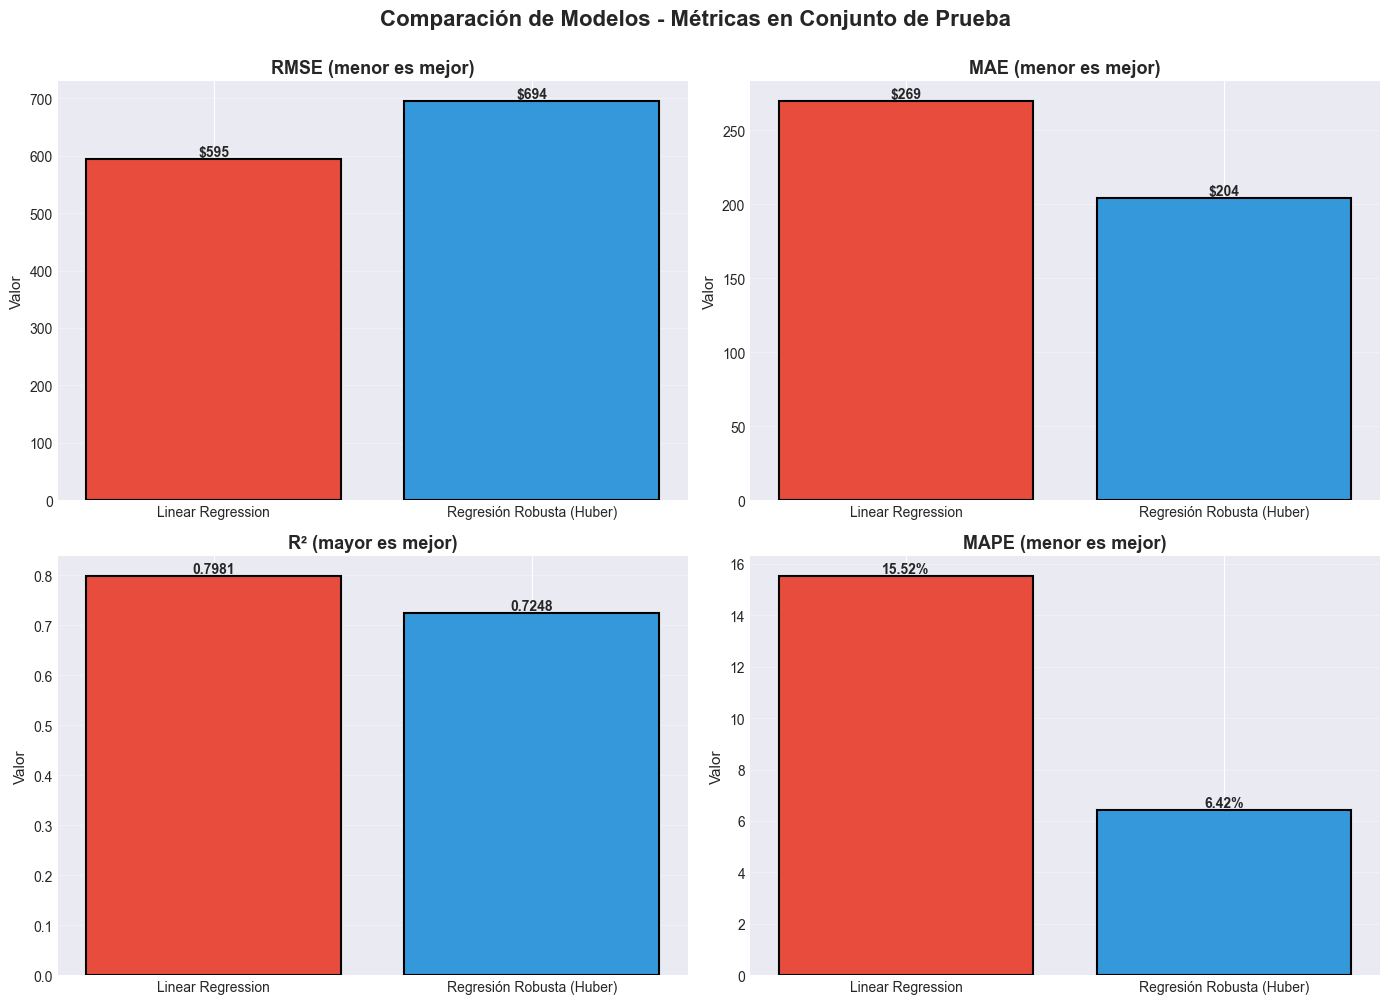

In [77]:
# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metricas = ['RMSE_Test', 'MAE_Test', 'R²_Test', 'MAPE_Test']
titulos = ['RMSE (menor es mejor)', 'MAE (menor es mejor)', 'R² (mayor es mejor)', 'MAPE (menor es mejor)']
colores = ['#e74c3c', '#3498db']

for idx, (metrica, titulo) in enumerate(zip(metricas, titulos)):
    ax = axes[idx // 2, idx % 2]
    valores = resultados[metrica].values
    barras = ax.bar(resultados['Modelo'], valores, color=colores, edgecolor='black', linewidth=1.5)
    ax.set_title(titulo, fontsize=13, fontweight='bold')
    ax.set_ylabel('Valor', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Añadir valores sobre las barras
    for barra, valor in zip(barras, valores):
        altura = barra.get_height()
        if metrica in ['RMSE_Test', 'MAE_Test']:
            texto = f'${valor:,.0f}'
        elif metrica == 'MAPE_Test':
            texto = f'{valor:.2f}%'
        else:
            texto = f'{valor:.4f}'
        ax.text(barra.get_x() + barra.get_width()/2., altura,
                texto, ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Comparación de Modelos - Métricas en Conjunto de Prueba', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [78]:
# Identificar mejor modelo
print("\n" + "=" * 70)
print("SELECCIÓN DEL MEJOR MODELO")
print("=" * 70)

# Comparar por MAE (métrica principal)
mejor_idx = resultados['MAE_Test'].idxmin()
mejor_modelo_nombre = resultados.loc[mejor_idx, 'Modelo']
mejor_mae = resultados.loc[mejor_idx, 'MAE_Test']
mejor_r2 = resultados.loc[mejor_idx, 'R²_Test']

print(f"\nMejor modelo (basado en MAE en test): {mejor_modelo_nombre}")
print(f"  MAE: ${mejor_mae:,.2f}")
print(f"  R²: {mejor_r2:.4f}")

# Diferencia entre modelos
diff_mae = abs(mae_test_lr - mae_test_huber)
diff_r2 = abs(r2_test_lr - r2_test_huber)
print(f"\nDiferencia en MAE: ${diff_mae:,.2f}")
print(f"Diferencia en R²: {diff_r2:.4f}")

if diff_mae < 100:  # Si la diferencia es pequeña
    print("\n→ Los dos modelos tienen desempeño muy similar")
else:
    mejora_porcentual = (diff_mae / max(mae_test_lr, mae_test_huber)) * 100
    print(f"\n→ El mejor modelo tiene una mejora de {mejora_porcentual:.2f}% en MAE")


SELECCIÓN DEL MEJOR MODELO

Mejor modelo (basado en MAE en test): Regresión Robusta (Huber)
  MAE: $204.08
  R²: 0.7248

Diferencia en MAE: $65.41
Diferencia en R²: 0.0734

→ Los dos modelos tienen desempeño muy similar


---
## 9. Análisis de Errores de Predicción

Análisis de los errores para ambos modelos.

### 9.1 Cálculo de Errores

In [79]:
# Calcular errores para ambos modelos
errores_lr = y_test_pred_lr - y_test
errores_abs_lr = np.abs(errores_lr)
errores_pct_lr = (errores_lr / y_test) * 100

errores_huber = y_test_pred_huber - y_test
errores_abs_huber = np.abs(errores_huber)
errores_pct_huber = (errores_huber / y_test) * 100

# Crear DataFrame con resultados
df_errores = pd.DataFrame({
    'y_real': y_test,
    'y_pred_lr': y_test_pred_lr,
    'error_lr': errores_lr,
    'error_abs_lr': errores_abs_lr,
    'error_pct_lr': errores_pct_lr,
    'y_pred_huber': y_test_pred_huber,
    'error_huber': errores_huber,
    'error_abs_huber': errores_abs_huber,
    'error_pct_huber': errores_pct_huber
})

print("=" * 70)
print("ANÁLISIS DE ERRORES - PRIMERAS 10 OBSERVACIONES")
print("=" * 70)
print("\nLinear Regression:")
print(df_errores[['y_real', 'y_pred_lr', 'error_lr', 'error_abs_lr', 'error_pct_lr']].head(10).to_string())
print("\nRegresión Robusta (Huber):")
print(df_errores[['y_real', 'y_pred_huber', 'error_huber', 'error_abs_huber', 'error_pct_huber']].head(10).to_string())

ANÁLISIS DE ERRORES - PRIMERAS 10 OBSERVACIONES

Linear Regression:
      y_real    y_pred_lr    error_lr  error_abs_lr  error_pct_lr
677     1379  1442.238616   63.238616     63.238616      4.585832
1046    1124  1347.913733  223.913733    223.913733     19.921151
610     2106  2607.569247  501.569247    501.569247     23.816204
49       942   946.268030    4.268030      4.268030      0.453082
1284    1763  1777.116167   14.116167     14.116167      0.800690
486     1379  1442.238616   63.238616     63.238616      4.585832
548      949   969.280830   20.280830     20.280830      2.137074
939     1899  1966.936079   67.936079     67.936079      3.577466
78      1406  1473.334368   67.334368     67.334368      4.789073
506     1975  2166.209338  191.209338    191.209338      9.681485

Regresión Robusta (Huber):
      y_real  y_pred_huber  error_huber  error_abs_huber  error_pct_huber
677     1379   1388.065482     9.065482         9.065482         0.657395
1046    1124   1120.551552    

### 9.2 Estadísticas de Errores

In [80]:
print("=" * 70)
print("ESTADÍSTICAS DE ERRORES")
print("=" * 70)

# Linear Regression
print("\n" + "─" * 70)
print("LINEAR REGRESSION")
print("─" * 70)
print(f"\nError (predicción - real):")
print(f"  Media:             ${errores_lr.mean():,.2f}")
print(f"  Mediana:           ${np.median(errores_lr):,.2f}")
print(f"  Desviación std:    ${errores_lr.std():,.2f}")
print(f"  Mínimo:            ${errores_lr.min():,.2f}")
print(f"  Máximo:            ${errores_lr.max():,.2f}")

print(f"\nError absoluto:")
print(f"  Media (MAE):       ${errores_abs_lr.mean():,.2f}")
print(f"  Mediana:           ${np.median(errores_abs_lr):,.2f}")
print(f"  Percentil 25:      ${np.percentile(errores_abs_lr, 25):,.2f}")
print(f"  Percentil 75:      ${np.percentile(errores_abs_lr, 75):,.2f}")
print(f"  Percentil 90:      ${np.percentile(errores_abs_lr, 90):,.2f}")
print(f"  Percentil 95:      ${np.percentile(errores_abs_lr, 95):,.2f}")

print(f"\nError porcentual:")
print(f"  Media (MAPE):      {errores_pct_lr.abs().mean():.2f}%")
print(f"  Mediana:           {np.median(errores_pct_lr.abs()):.2f}%")

# Sesgo
if abs(errores_lr.mean()) > 100:
    if errores_lr.mean() > 0:
        print(f"\n→ Sesgo positivo: El modelo tiende a SOBRESTIMAR los costos")
    else:
        print(f"\n→ Sesgo negativo: El modelo tiende a SUBESTIMAR los costos")
else:
    print(f"\n→ Sesgo mínimo: El modelo está bien calibrado en promedio")

# Regresión Robusta
print("\n" + "─" * 70)
print("REGRESIÓN ROBUSTA (HUBER)")
print("─" * 70)
print(f"\nError (predicción - real):")
print(f"  Media:             ${errores_huber.mean():,.2f}")
print(f"  Mediana:           ${np.median(errores_huber):,.2f}")
print(f"  Desviación std:    ${errores_huber.std():,.2f}")
print(f"  Mínimo:            ${errores_huber.min():,.2f}")
print(f"  Máximo:            ${errores_huber.max():,.2f}")

print(f"\nError absoluto:")
print(f"  Media (MAE):       ${errores_abs_huber.mean():,.2f}")
print(f"  Mediana:           ${np.median(errores_abs_huber):,.2f}")
print(f"  Percentil 25:      ${np.percentile(errores_abs_huber, 25):,.2f}")
print(f"  Percentil 75:      ${np.percentile(errores_abs_huber, 75):,.2f}")
print(f"  Percentil 90:      ${np.percentile(errores_abs_huber, 90):,.2f}")
print(f"  Percentil 95:      ${np.percentile(errores_abs_huber, 95):,.2f}")

print(f"\nError porcentual:")
print(f"  Media (MAPE):      {errores_pct_huber.abs().mean():.2f}%")
print(f"  Mediana:           {np.median(errores_pct_huber.abs()):.2f}%")

# Sesgo
if abs(errores_huber.mean()) > 100:
    if errores_huber.mean() > 0:
        print(f"\n→ Sesgo positivo: El modelo tiende a SOBRESTIMAR los costos")
    else:
        print(f"\n→ Sesgo negativo: El modelo tiende a SUBESTIMAR los costos")
else:
    print(f"\n→ Sesgo mínimo: El modelo está bien calibrado en promedio")

ESTADÍSTICAS DE ERRORES

──────────────────────────────────────────────────────────────────────
LINEAR REGRESSION
──────────────────────────────────────────────────────────────────────

Error (predicción - real):
  Media:             $-6.67
  Mediana:           $50.52
  Desviación std:    $595.85
  Mínimo:            $-3,691.45
  Máximo:            $3,822.46

Error absoluto:
  Media (MAE):       $269.48
  Mediana:           $131.93
  Percentil 25:      $51.52
  Percentil 75:      $266.93
  Percentil 90:      $463.26
  Percentil 95:      $1,051.80

Error porcentual:
  Media (MAPE):      15.52%
  Mediana:           8.79%

→ Sesgo mínimo: El modelo está bien calibrado en promedio

──────────────────────────────────────────────────────────────────────
REGRESIÓN ROBUSTA (HUBER)
──────────────────────────────────────────────────────────────────────

Error (predicción - real):
  Media:             $-145.57
  Mediana:           $-0.80
  Desviación std:    $680.33
  Mínimo:            $-4,748.6

### 9.3 Visualización: Predicciones vs Valores Reales

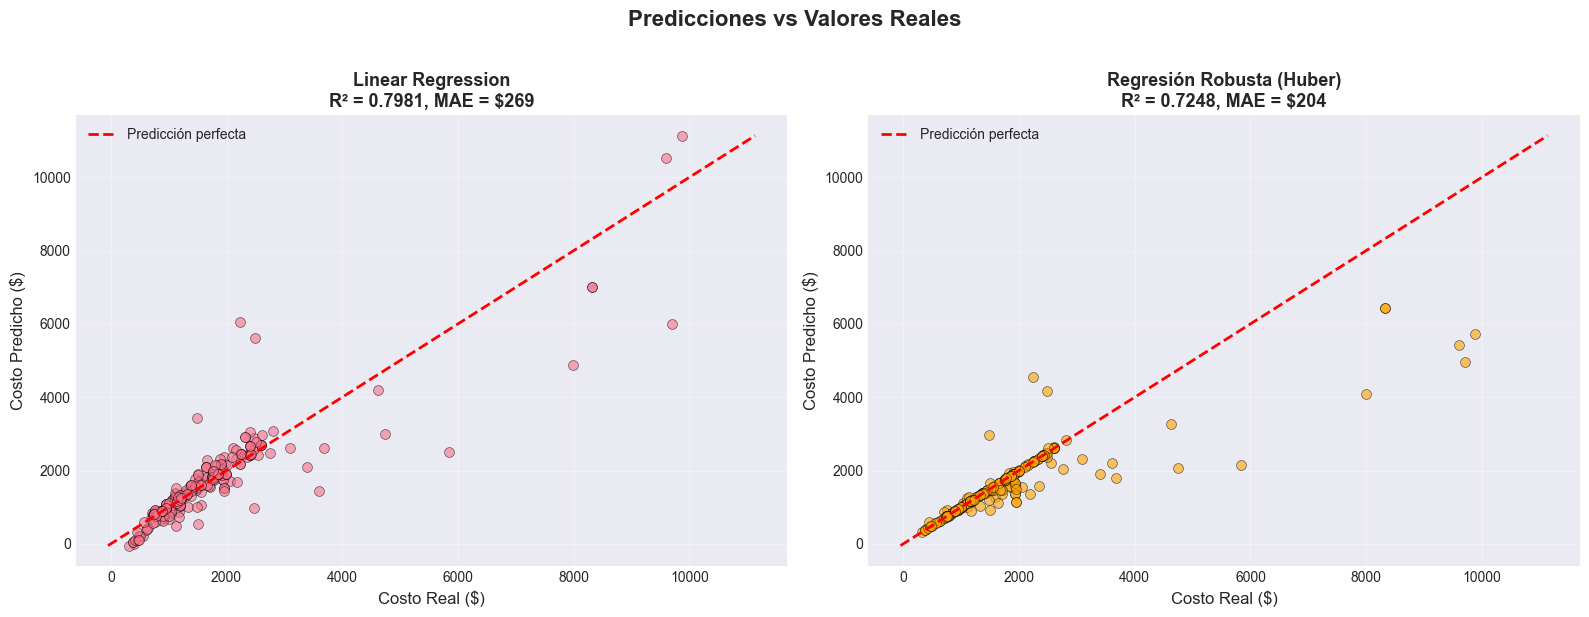


Interpretación:
- Puntos sobre la línea roja: predicción perfecta
- Puntos arriba de la línea: modelo SOBRESTIMA el costo
- Puntos abajo de la línea: modelo SUBESTIMA el costo


In [81]:
# Gráfico de predicciones vs valores reales
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear Regression
axes[0].scatter(y_test, y_test_pred_lr, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
# Línea de identidad (predicción perfecta)
min_val = min(y_test.min(), y_test_pred_lr.min())
max_val = max(y_test.max(), y_test_pred_lr.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción perfecta')
axes[0].set_xlabel('Costo Real ($)', fontsize=12)
axes[0].set_ylabel('Costo Predicho ($)', fontsize=12)
axes[0].set_title(f'Linear Regression\nR² = {r2_test_lr:.4f}, MAE = ${mae_test_lr:,.0f}', 
                  fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Regresión Robusta
axes[1].scatter(y_test, y_test_pred_huber, alpha=0.6, s=50, edgecolors='black', linewidth=0.5, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción perfecta')
axes[1].set_xlabel('Costo Real ($)', fontsize=12)
axes[1].set_ylabel('Costo Predicho ($)', fontsize=12)
axes[1].set_title(f'Regresión Robusta (Huber)\nR² = {r2_test_huber:.4f}, MAE = ${mae_test_huber:,.0f}', 
                  fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Predicciones vs Valores Reales', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nInterpretación:")
print("- Puntos sobre la línea roja: predicción perfecta")
print("- Puntos arriba de la línea: modelo SOBRESTIMA el costo")
print("- Puntos abajo de la línea: modelo SUBESTIMA el costo")

In [87]:
# ¿En cuántos casos cada modelo es mejor?
lr_mejor = (errores_abs_lr < errores_abs_huber).sum()
huber_mejor = (errores_abs_huber < errores_abs_lr).sum()
empate = (errores_abs_lr == errores_abs_huber).sum()

print("=" * 70)
print("¿QUÉ MODELO TIENE MENOR ERROR EN CADA OBSERVACIÓN?")
print("=" * 70)
print(f"\nLinear Regression es mejor en:    {lr_mejor:4d} casos ({lr_mejor/len(y_test)*100:.2f}%)")
print(f"Regresión Robusta es mejor en:    {huber_mejor:4d} casos ({huber_mejor/len(y_test)*100:.2f}%)")
print(f"Empate:                            {empate:4d} casos ({empate/len(y_test)*100:.2f}%)")
print(f"\nTotal de observaciones:            {len(y_test):4d}")

¿QUÉ MODELO TIENE MENOR ERROR EN CADA OBSERVACIÓN?

Linear Regression es mejor en:      47 casos (17.80%)
Regresión Robusta es mejor en:     217 casos (82.20%)
Empate:                               0 casos (0.00%)

Total de observaciones:             264
